In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.8 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
%cd /content/drive/MyDrive/IS403/Project/Data/

/content/drive/.shortcut-targets-by-id/1H00NdDTisvXwJcMmLshBS2Qn7PUvkU8H/IS403/Project/Data


# Eval Function

In [5]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [6]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [7]:
def train_test_valid(data):
  test_size  = 0.3
  valid_size = 0.1

  test_split_idx  = int(data.shape[0] * (1-test_size))
  valid_split_idx = int(data.shape[0] * (1-(valid_size+test_size)))

  return data[:valid_split_idx], data[valid_split_idx:test_split_idx+1], data[test_split_idx+1:]

# AMAZON

## Data

In [8]:
df_amz = pd.read_csv("AMZN.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,58.602501,58.982498,57.599998,58.117500,58.117500,82142000
1,2017-12-04,58.692501,58.759998,56.400002,56.697498,56.697498,118638000
2,2017-12-05,56.412998,57.963501,56.237000,57.078499,57.078499,81596000
3,2017-12-06,56.899502,57.794498,56.804001,57.617500,57.617500,57066000
4,2017-12-07,57.829498,58.159500,57.549999,57.989498,57.989498,50232000
...,...,...,...,...,...,...,...
1384,2023-06-05,123.360001,125.800003,123.029999,125.300003,125.300003,47950100
1385,2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
1386,2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
1387,2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


## Preprocessing

### Check null and na value

In [9]:
df_amz.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
df_amz.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [11]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [12]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [13]:
close_amz=df_amz[['Close']]

## EDA

### Get the duration of dataset

In [14]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

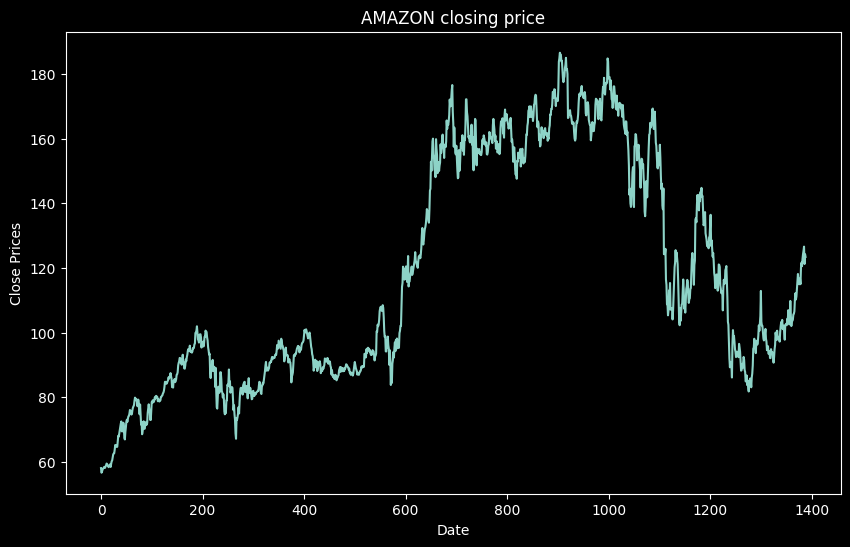

In [15]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_amz)
plt.title('AMAZON closing price')
plt.show()

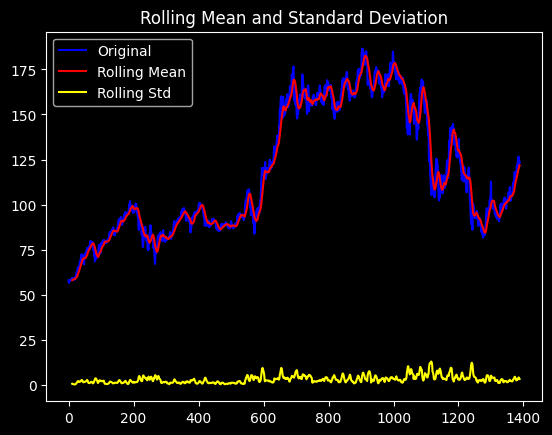

Results of dickey fuller test
Test Statistics                  -1.929368
p-value                           0.318374
No. of lags used                  0.000000
Number of observations used    1388.000000
critical value (1%)              -3.435070
critical value (5%)              -2.863625
critical value (10%)             -2.567880
dtype: float64


In [16]:
test_stationarity(close_amz)

## Train, test, valid

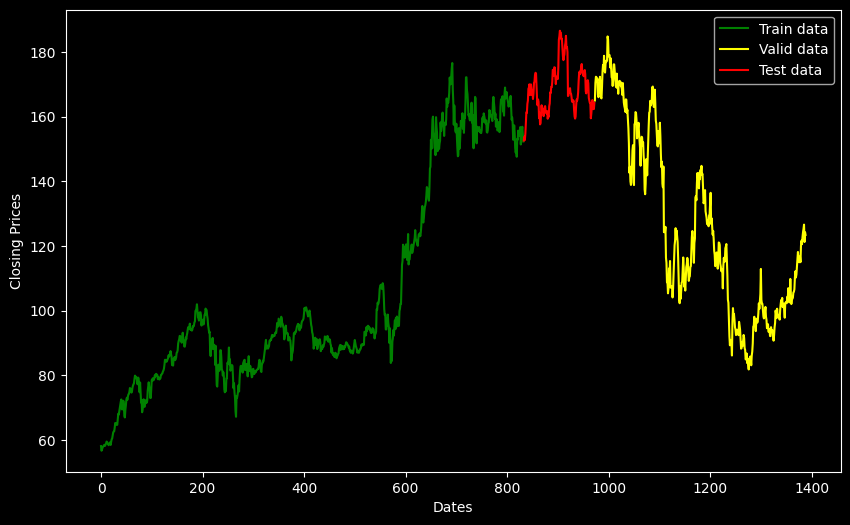

In [17]:
close_amz = close_amz.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_amz)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [18]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [19]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_amz[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10188.771, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.76 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3723.944, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=2.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3725.925, Time=1.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=1.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.82 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3723.511, Time=1.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7055.752, Time=0.82 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3723.960, Time=3.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3725.500, Time=2.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8123.950, Time=0.12 sec
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1857.756
Date:                Wed, 21 Jun 2023   AIC                           3723.511
Time:                        03:49:30   BIC                           3742.411
Sample:                             0   HQIC                          3730.758
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1469      0.193      0.759      0.448      -0.232       0.526
ar.L1          0.9986      0.002    558.593      0.000       0.995       1.002
ma.L1         -0.0666      0.025     -2.657      0.008      -0.116      -0.017
sigma2         5.0310      0.154     32.612      0.000       4.729       5.333
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               355.17
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.24   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [20]:
model = ARIMA(y_train, order=(1,0,1),exog=df_amz[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -972.725
Date:                Wed, 21 Jun 2023   AIC                           1959.449
Time:                        03:49:31   BIC                           1992.525
Sample:                             0   HQIC                          1972.131
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1658      0.077      2.142      0.032       0.014       0.317
High           0.8216      0.018     46.078      0.000       0.787       0.857
Open          -0.5856      0.020    -29.365      0.000      -0.625      -0.547
Low            0.7626      0.011     72.453      0.000       0.742       0.783
ar.L1          0.1801      0.102      1.766      0.077      -0.020       0.380
ma.L1         -0.4093      0.099     -4.147      0.000      -0.603      -0.216
sigma2         0.5998      0.019     31.945      0.000       0.563       0.637
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               512.42
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [21]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_amz[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=df_amz[['High','Open','Low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [22]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  0.5900151934822
MAPE:  0.34984803767158856
RMSE:  0.7707595610298451

** Validate **
MAE:  0.896455354029334
MAPE:  0.7246806800388395
RMSE:  1.1518192627372792


## Forecast

In [23]:
last_index =  close_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_amz[['High','Open','Low']][last_index-586:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1389    109.344001
1390    106.578516
1391    102.800897
1392    103.235330
1393    105.222620
1394    104.601508
1395    104.953816
1396    105.659150
1397    106.319137
1398    110.176258
1399    112.465281
1400    110.385491
1401    110.636066
1402    114.121176
1403    115.144087
1404    117.982309
1405    116.395112
1406    114.838222
1407    116.247903
1408    116.725305
1409    115.048126
1410    120.501499
1411    120.889273
1412    120.178917
1413    122.394827
1414    125.419015
1415    125.092952
1416    126.908274
1417    122.415037
1418    124.571078
Name: predicted_mean, dtype: float64


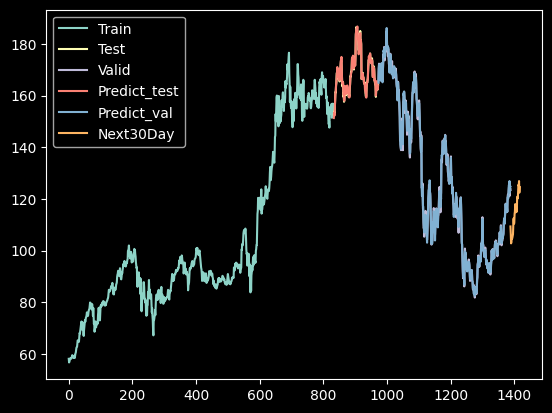

In [24]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# NVIDIA

## Data

In [25]:
df_nvda = pd.read_csv("NVDA.csv")
df_nvda

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,49.827499,50.032501,48.117500,49.419998,48.908009,81154800
1,2017-12-04,50.012501,50.075001,46.125000,46.665001,46.181549,124084400
2,2017-12-05,45.599998,48.174999,45.145000,46.935001,46.448750,98148800
3,2017-12-06,46.424999,47.535000,46.209999,47.314999,46.824821,46703200
4,2017-12-07,47.990002,48.400002,47.529999,47.997501,47.500244,54260000
...,...,...,...,...,...,...,...
1384,2023-06-05,389.089996,395.649994,387.070007,391.709991,391.669464,39609400
1385,2023-06-06,388.299988,391.600006,381.480011,386.540009,386.500000,38872900
1386,2023-06-07,389.149994,394.989990,373.559998,374.750000,374.750000,51199800
1387,2023-06-08,377.239990,388.640015,375.049988,385.100006,385.100006,41777200


## Preprocessing

### Check null and na value

In [26]:
df_nvda.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [27]:
df_nvda.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [28]:
print("Date column data type: ", type(df_nvda['Date'][0]))
print("Open column data type: ", type(df_nvda['Open'][0]))
print("Close column data type: ", type(df_nvda['Close'][0]))
print("High column data type: ", type(df_nvda['High'][0]))
print("Low column data type: ", type(df_nvda['Low'][0]))
print("Adj Close column data type: ", type(df_nvda['Adj Close'][0]))
print("Volume column data type: ", type(df_nvda['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [29]:
df_nvda['Date'] = pd.to_datetime(df_nvda.Date)

### Choose X

In [30]:
close_nvda=df_nvda[['Close']]

## EDA

### Get the duration of dataset

In [31]:
print("Starting date: ",df_nvda.iloc[0][0])
print("Ending date: ", df_nvda.iloc[-1][0])
print("Duration: ", df_nvda.iloc[-1][0]-df_nvda.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

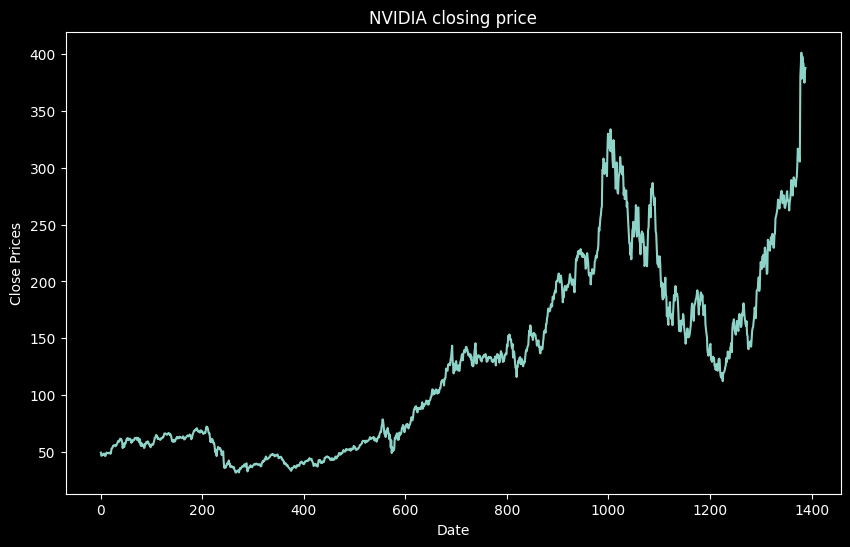

In [32]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_nvda)
plt.title('NVIDIA closing price')
plt.show()

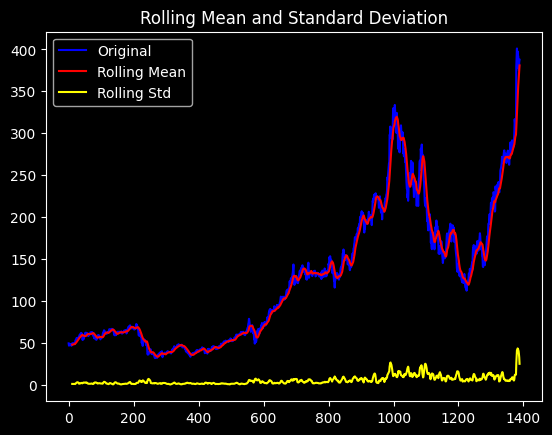

Results of dickey fuller test
Test Statistics                   0.624465
p-value                           0.988203
No. of lags used                 17.000000
Number of observations used    1371.000000
critical value (1%)              -3.435129
critical value (5%)              -2.863650
critical value (10%)             -2.567894
dtype: float64


In [33]:
test_stationarity(close_nvda)

## Train, test, valid

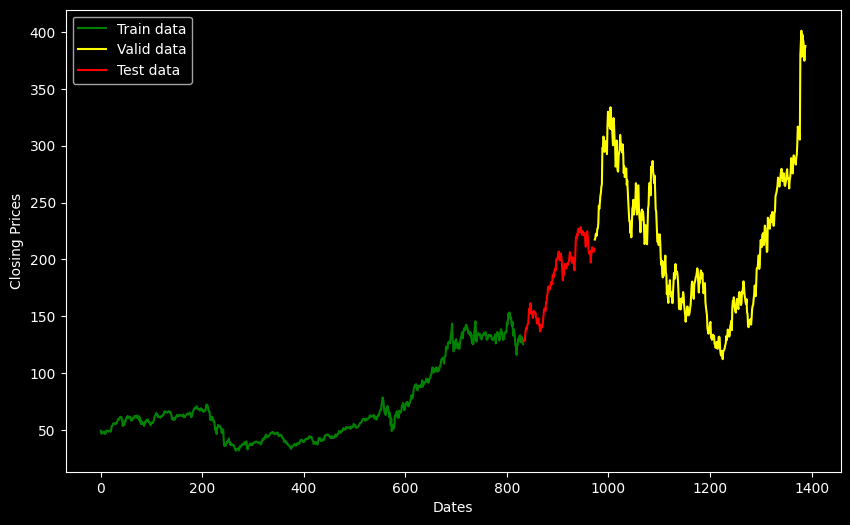

In [34]:
close_nvda = close_nvda.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_nvda)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [35]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [36]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_nvda[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9635.031, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8523.506, Time=0.95 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3763.002, Time=1.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.45 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3760.655, Time=1.37 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7618.689, Time=2.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3766.804, Time=1.95 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3761.969, Time=1.53 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=6859.316, Time=3.29 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3762.853, Time=3.71 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3760.555, Time=0.53 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6352.608, Time=0.79 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3762.664, Time=0.49 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -1875.278
Date:                Wed, 21 Jun 2023   AIC                           3760.555
Time:                        03:50:00   BIC                           3784.180
Sample:                             0   HQIC                          3769.613
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0724      0.208      0.348      0.728      -0.336       0.481
ar.L1          0.9991      0.002    505.017      0.000       0.995       1.003
ma.L1         -0.1484      0.020     -7.422      0.000      -0.188      -0.109
ma.L2          0.0768      0.022      3.548      0.000       0.034       0.119
sigma2         5.2440      0.145     36.138      0.000       4.960       5.528
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               805.48
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.51   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [37]:
model = ARIMA(y_train, order=(1,0,2),exog=df_nvda[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1021.481
Date:                Wed, 21 Jun 2023   AIC                           2058.962
Time:                        03:50:01   BIC                           2096.762
Sample:                             0   HQIC                          2073.456
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0478      0.064     -0.744      0.457      -0.174       0.078
High           0.7867      0.017     45.323      0.000       0.753       0.821
Open          -0.5481      0.019    -28.179      0.000      -0.586      -0.510
Low            0.7625      0.011     68.933      0.000       0.741       0.784
ar.L1         -0.2403      0.681     -0.353      0.724      -1.575       1.094
ma.L1         -0.0226      0.683     -0.033      0.974      -1.362       1.316
ma.L2         -0.0948      0.177     -0.536      0.592      -0.442       0.252
sigma2         0.6797      0.021     32.479      0.000       0.639       0.721
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1241.41
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               6.12   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [38]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_nvda[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=df_nvda[['High','Open','Low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [39]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  1.0553502128944485
MAPE:  0.582329701599994
RMSE:  1.309025660777191

** Validate **
MAE:  2.357809590735302
MAPE:  1.0938749202680353
RMSE:  3.1402349097471816


## Forecast

In [40]:
last_index =  close_nvda.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_nvda[['High','Open','Low']][last_index-586:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1389    269.290909
1390    275.517239
1391    287.779490
1392    283.739214
1393    279.994916
1394    275.265425
1395    285.098939
1396    289.662147
1397    286.415117
1398    287.019308
1399    284.695015
1400    283.844214
1401    286.254469
1402    296.702486
1403    299.777996
1404    314.852082
1405    311.273849
1406    312.482902
1407    309.741506
1408    302.423497
1409    378.733203
1410    386.741521
1411    411.983160
1412    388.906555
1413    396.405051
1414    396.606136
1415    393.086027
1416    386.070386
1417    382.231930
1418    384.901037
Name: predicted_mean, dtype: float64


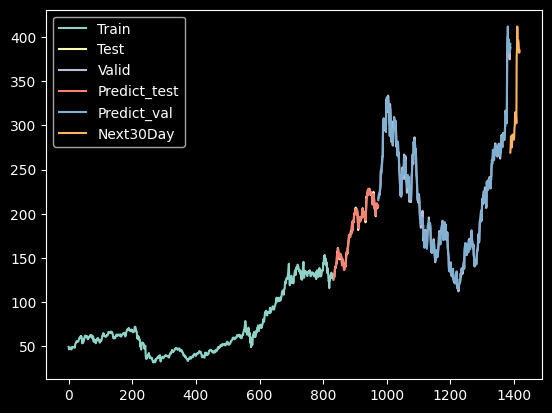

In [41]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# TESLA

## Data

In [42]:
df_tsla = pd.read_csv("TSLA.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,20.362667,20.688000,20.336666,20.435333,20.435333,64393500
1,2017-12-04,20.433332,20.551332,20.040667,20.346666,20.346666,87526500
2,2017-12-05,20.133333,20.533333,20.066668,20.246668,20.246668,69697500
3,2017-12-06,20.006666,20.892668,20.000000,20.884001,20.884001,107929500
4,2017-12-07,20.799999,21.242001,20.736668,20.749332,20.749332,71709000
...,...,...,...,...,...,...,...
1384,2023-06-05,217.800003,221.289993,214.520004,217.610001,217.610001,151143100
1385,2023-06-06,216.139999,221.910004,212.529999,221.309998,221.309998,146911600
1386,2023-06-07,228.000000,230.830002,223.199997,224.570007,224.570007,185710800
1387,2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700


## Preprocessing

### Check null and na value

In [43]:
df_tsla.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [44]:
df_tsla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [45]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [46]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

### Choose X

In [47]:
close_tsla=df_tsla[['Close']]

## EDA

### Get the duration of dataset

In [48]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

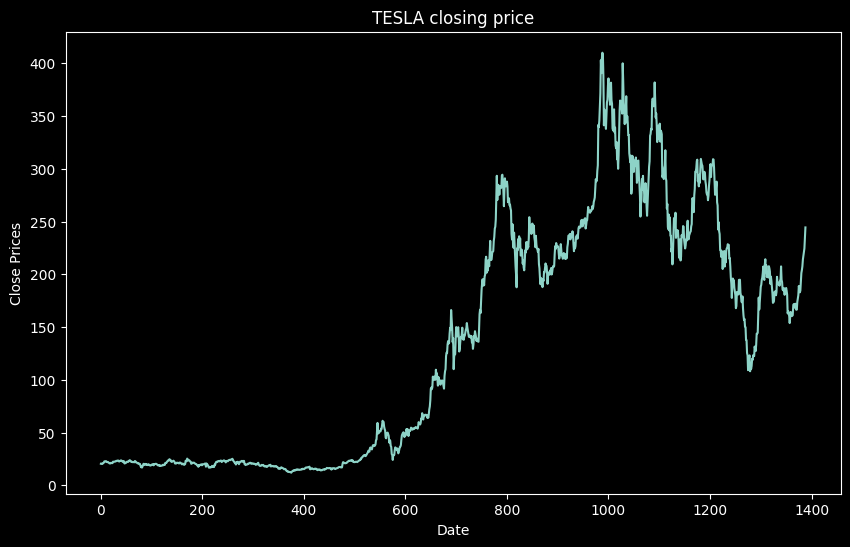

In [49]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(close_tsla)
plt.title('TESLA closing price')
plt.show()

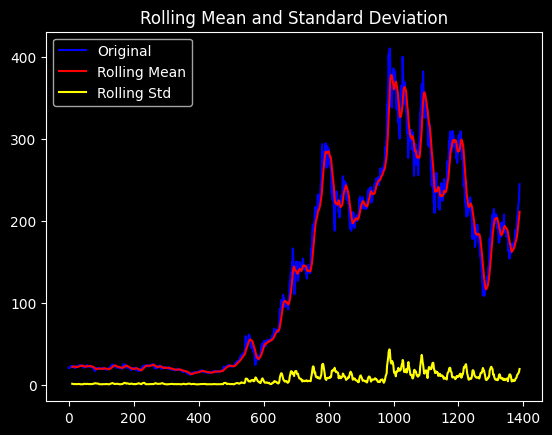

Results of dickey fuller test
Test Statistics                  -1.267376
p-value                           0.643963
No. of lags used                 24.000000
Number of observations used    1364.000000
critical value (1%)              -3.435153
critical value (5%)              -2.863661
critical value (10%)             -2.567899
dtype: float64


In [50]:
test_stationarity(close_tsla)

## Train, test, valid

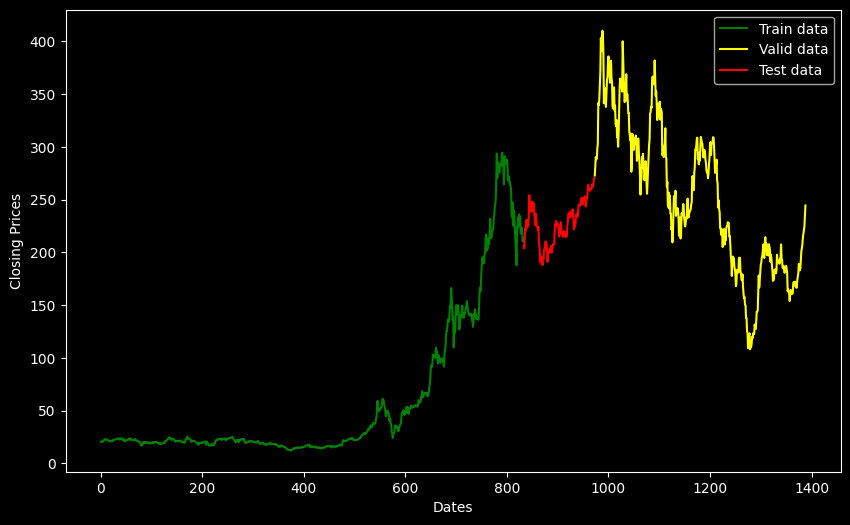

In [51]:
close_tsla = close_tsla.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_tsla)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [52]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [53]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= df_tsla[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9904.470, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8810.800, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4749.778, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4750.431, Time=0.80 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4751.708, Time=0.89 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7876.798, Time=2.47 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4750.703, Time=0.70 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 7.651 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2371.889
Date:                Wed, 21 Jun 2023   AIC                           4749.778
Time:                        03:50:11   BIC                           4763.953
Sample:                             0   HQIC                          4755.213
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.001   1929.705      0.000       0.999       1.001
ma.L1         -0.0704      0.015     -4.847      0.000      -0.099      -0.042
sigma2        17.2616      0.290     59.493      0.000      16.693      17.830
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8974.25
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              93.60   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [54]:
model = ARIMA(y_train, order=(1,0,1),exog=df_tsla[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  833
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1448.274
Date:                Wed, 21 Jun 2023   AIC                           2910.549
Time:                        03:50:12   BIC                           2943.624
Sample:                             0   HQIC                          2923.231
                                - 833                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0642      0.120     -0.533      0.594      -0.300       0.172
High           0.9495      0.011     83.985      0.000       0.927       0.972
Open          -0.6206      0.012    -51.546      0.000      -0.644      -0.597
Low            0.6678      0.007     99.909      0.000       0.655       0.681
ar.L1         -0.2620      0.050     -5.291      0.000      -0.359      -0.165
ma.L1         -0.0122      0.051     -0.237      0.812      -0.112       0.088
sigma2         1.8971      0.033     58.182      0.000       1.833       1.961
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10093.40
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              93.59   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [55]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=df_tsla[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=df_tsla[['High','Open','Low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [56]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  1.5622722566838014
MAPE:  0.6884176001390814
RMSE:  2.026416421643197

** Validate **
MAE:  3.0569545136059424
MAPE:  1.2048646202180446
RMSE:  4.0644253513935125


## Forecast

In [57]:
last_index =  close_tsla.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog=df_tsla[['High','Open','Low']][last_index-586:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
1389    159.333773
1390    161.804908
1391    159.771316
1392    162.737083
1393    164.086767
1394    160.291012
1395    169.530835
1396    170.130987
1397    167.555947
1398    169.779157
1399    171.425353
1400    170.762997
1401    166.957315
1402    167.843298
1403    172.755477
1404    175.093026
1405    180.482976
1406    187.827715
1407    191.309667
1408    180.773591
1409    182.105504
1410    197.157994
1411    201.815273
1412    199.901297
1413    206.550100
1414    215.863712
1415    218.137424
1416    218.427460
1417    226.661930
1418    233.058765
Name: predicted_mean, dtype: float64


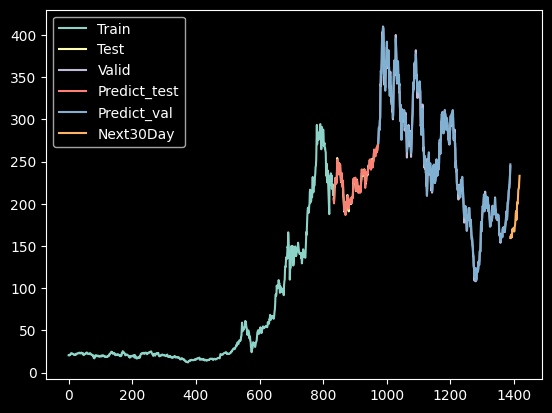

In [58]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()